**Oбучение с подкреплением**

Евгений Борисов <esborisov@sevsu.ru>

---

In [27]:
import numpy as np

In [ ]:
# !pip3 install gym
# !pip3 install gym[atari]
# !pip3 install gym[accept-rom-license]
# !pip3 install pygame

In [ ]:
# !pip3 install ale-py
# !ale-import-roms roms/

In [ ]:
# https://pypi.org/project/gym-notebook-wrapper/

----

In [ ]:
# !pip3 install mujoco_py

# env_name = 'Ant-v3'

In [ ]:
# !pacman -S xorg-server-xvfb
# !pip3 install pyvirtualdisplay
# !pip3 install xvfbwrapper
# !pip3 install box2d

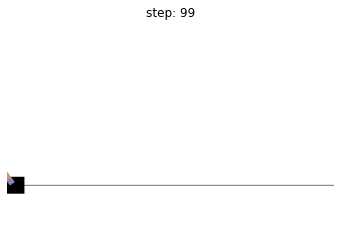

In [11]:
# блокируем всплывающее окно gym env
from pyvirtualdisplay import Display
display = Display(visible=0, size=(800,600))
display.start()

import matplotlib.pyplot as plt
from IPython import display
import gym 

env_name = 'CartPole-v0'
# env_name = 'Pendulum-v1' 

env = gym.make(env_name)
obs = env.reset()

img = plt.imshow(env.render(mode='rgb_array'))
plt.grid(False)
plt.axis(False)

for i in range(100):
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)

    plt.title(f'step: {i}')
    img.set_data(env.render(mode='rgb_array')) 
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    # if done: break
        
env.close()

In [17]:
obs, reward, done

(array([-2.345508  , -3.5949326 ,  5.6348996 , -0.32612374], dtype=float32),
 0.0,
 True)

---

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# from tensorflow.keras.optimizers import Adam
# from keras.layers import Dropout
# from keras.optimizers import SGD

In [19]:
def create_model(env):
    md = Sequential()
    md.add(Dense(256, activation='relu',input_shape=env.observation_space.shape))
    md.add(Dense(256, activation='relu'))
    md.add(Dense(env.action_space.n))
    md.compile(loss='mean_squared_error', optimizer='SGD')
    
    #md.add(Dense(env.action_space.n, activation='softmax'))
    #md.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4))
    return md

In [20]:
model = create_model(env)
model_target = create_model(env)

2022-05-23 16:48:03.836359: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 16:48:03.864301: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 16:48:03.864584: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 16:48:03.864949: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [21]:
HISTORY_DEEP = 2000 # глубина истории переходов
BATCH_SIZE = 32 # размер батча для обучения модели

GAMMA = 0.85 # коэффициент для расчёта оценки reward
TAU = 0.125 # определяет различие весов основной и таргет моделей

# вероятность использования случайного действия при обучении
EPSILON_MAX = 1.0 # в начальном состоянии используем случайный выбор действия
EPSILON_MIN = 0.05 # когда модель начала обучаться позволяем ей оценивать действия
EPSILON_DECAY = 0.995 # шаг изменения вероятности

MAX_EPOCH = 100 # максимальное количество эпох обучения
MAX_STEP = 256  # максимальное количество шагов в эпохе (длительность одной игры)

In [22]:
def reshape_state(s): return s[np.newaxis,:]

In [23]:
# выбор действия
def get_action(model,state,eps=EPSILON_MAX): # с вероятностью eps выбираем случайное действие
    if np.random.rand()<eps: return env.action_space.sample(), 1
    return np.argmax( model.predict( state )[0] ), 0

In [24]:
def replay(model, model_target, history, batch_size=BATCH_SIZE,gamma=GAMMA):

    if len(history) < batch_size: return
    
    samples = [ history[i] for i in np.random.permutation(len(history))[:batch_size] ] 

    for s in samples:
        target = model_target.predict( s['state0'] )
        
        target[0][ s['act'] ] = s['reward'] 
        
        if s['isdone']:
            target[0][ s['act'] ] = s['reward']
        else:
            target[0][ s['act'] ] = s['reward'] + gamma*max(model_target.predict(s['state1'])[0])
            
        # model.fit( s['state0'], target, epochs=1, verbose=0)
        model.train_on_batch(s['state0'], target)

In [25]:
def target_train(model, model_target,tau=TAU):
    weights = model.get_weights()
    target_weights = model_target.get_weights()
    for i in range(len(target_weights)):
        target_weights[i] = weights[i] * tau + target_weights[i] * (1. - tau)
    model_target.set_weights(target_weights)

In [ ]:
%%time

history = []

epsilon = EPSILON_MAX # вероятность использования случайного действия при обучении

for e in range(MAX_EPOCH):
    # инициализируем среду
    state0 = env.reset() 
    state0 = reshape_state(state0)
    for st in range(MAX_STEP):
        
        # выбираем действие
        act, is_act_rand = get_action(model,state0,epsilon)
        # применяем действие
        state1, reward, done, _ = env.step(act)
        state1 = reshape_state(state1)
    
        # сохраняем историю
        history.append({'state0':state0,'state1':state1,'act':act,'reward':reward,'isdone':done})
        history = history[-HISTORY_DEEP:] # ограничиваем историю

        # коррекция основной модели
        replay(model, model_target, history)
        
        # коррекция таргет модели
        target_train(model, model_target)
                
        if done: break
        state0 = state1
        epsilon = max(EPSILON_MIN, epsilon*EPSILON_DECAY)
                
    print('%d/%d : %d steps'%(e+1,MAX_EPOCH,st+1))  
    
    if st>200: 
        print('STEP BOUND!')
        break

2022-05-23 16:48:32.290569: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


1/100 : 36 steps
2/100 : 30 steps


2022-05-23 16:49:49.150557: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


3/100 : 40 steps


2022-05-23 16:51:31.859952: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


4/100 : 16 steps
5/100 : 57 steps


2022-05-23 16:53:45.014972: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


6/100 : 63 steps
7/100 : 31 steps
8/100 : 31 steps


2022-05-23 16:58:25.445852: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-05-23 16:58:42.215438: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-05-23 16:58:56.797570: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


9/100 : 38 steps
10/100 : 54 steps
11/100 : 53 steps
12/100 : 54 steps
13/100 : 53 steps


2022-05-23 17:07:58.021202: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


14/100 : 44 steps


2022-05-23 17:11:00.005773: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


15/100 : 136 steps
16/100 : 74 steps
17/100 : 124 steps


2022-05-23 17:20:36.005784: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-05-23 17:21:28.776502: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-05-23 17:22:06.006754: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-05-23 17:22:08.148416: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


18/100 : 178 steps


2022-05-23 17:28:14.640989: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


19/100 : 63 steps


2022-05-23 17:29:12.016132: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-05-23 17:30:31.287589: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


20/100 : 125 steps


2022-05-23 17:33:43.727638: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-05-23 17:34:35.970326: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


In [ ]:
# len(history)
# history

In [ ]:
model.save('CartPole-%d.model'%(st))

---

In [ ]:
# from tensorflow.keras.models import load_model
# model = load_model('CartPole-12.model')

In [ ]:
# s = env.reset()[np.newaxis,:]
# env.render()
# #while True:
# for t in range(350):    
#     a = np.argmax( model.predict(s)[0] )   
#     s,r,d,_ = env.step(a)
#     s=s[np.newaxis,:]
#     env.render()
#     if d: 
#         print(t) 
#         break
# env.close()    

In [ ]:
# блокируем всплывающее окно gym env
#from pyvirtualdisplay import Display
#display = Display(visible=0, size=(800,600))
#display.start()

#import matplotlib.pyplot as plt
#from IPython import display
#import gym 

# env_name = 'CartPole-v0'
# env_name = 'Pendulum-v1' 

# env = gym.make(env_name)
obs = env.reset()

img = plt.imshow(env.render(mode='rgb_array'))
plt.grid(False)
plt.axis(False)

for i in range(500):
    # action = env.action_space.sample()
    action = np.argmax( model.predict(obs[np.newaxis,:])[0] )   

    obs, reward, done, info = env.step(action)

    plt.title(f'step: {i}')
    img.set_data(env.render(mode='rgb_array')) 
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    if done: break
        
env.close()

----

In [8]:
# import gym 
# import matplotlib.pyplot as plt
# from IPython import display

# env_name = 'BreakoutNoFrameskip-v4'
# # env_name = 'SpaceInvaders-v0'

# env = gym.make(env_name,render_mode='rgb_array')

# obs = env.reset()

# img = plt.imshow(env.render(mode='rgb_array')) # only call this once
# plt.grid(False)
# plt.axis(False)

# for i in range(300):
#     action = env.action_space.sample()
#     obs, reward, done, info = env.step(action)

#     plt.title(f'step: {i}')
#     img.set_data(env.render(mode='rgb_array')) 
#     display.display(plt.gcf())
#     display.clear_output(wait=True)
    
#     if done: break
        
# env.close()